In [24]:
# your imports

import torch
import torchvision
from typing import Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from torch.utils.data import Dataset, DataLoader

### Task 1: Loading the data

**Instructions:**
1. Create a PyTorch Dataset for the training and validation splits of the PCAM dataset in your tmp folder.
2. Make sure the Dataset objects each have a \_\_len\_\_ method and a \_\_getitem\_\_ method.

In [25]:
class H5Dataset(Dataset):
    def __init__(self, file_path_d,file_path_t, transform):
        self.file_d = h5py.File(file_path_d, 'r')
        self.data = self.file_d['x']
        self.file_t = h5py.File(file_path_t, 'r')
        self.target = self.file_t['y']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = (torch.from_numpy(self.data[idx]).permute((2,0,1)),torch.from_numpy(self.target[idx].squeeze()))

        if self.transform:
            sample = self.transform(sample)
        return sample


train_dataset = H5Dataset("data/camelyonpatch_level_2_split_train_x.h5","data/camelyonpatch_level_2_split_train_y.h5", transform = None)
val_dataset = H5Dataset("data/camelyonpatch_level_2_split_valid_x.h5","data/camelyonpatch_level_2_split_valid_y.h5", transform = None)

The training dataset consists of 262144 images of shape (3, 96, 96)
The validation dataset consists of 32768 images of shape (3, 96, 96)



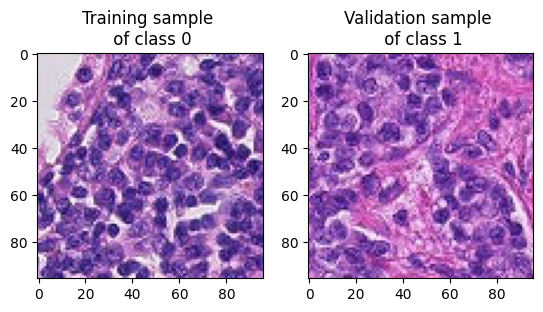

In [26]:
# Checkpoint

N_train = train_dataset.__len__()
train_sample = train_dataset.__getitem__(0)[0]
train_sample_target = train_dataset.__getitem__(0)[1]
train_shape = train_sample.shape

print("The training dataset consists of {} images of shape ({}, {}, {})".format(N_train, train_shape[0], train_shape[1], train_shape[2]))

N_val = val_dataset.__len__()
val_sample = val_dataset.__getitem__(0)[0]
val_sample_target = val_dataset.__getitem__(0)[1]
val_shape = val_sample.shape

print("The validation dataset consists of {} images of shape ({}, {}, {})".format(N_val, val_shape[0], val_shape[1], val_shape[2]))
print()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_sample.permute((2,1,0)))
axs[0].set_title("Training sample \n of class {}".format(train_sample_target))

axs[1].imshow(val_sample.permute((2,1, 0)))
axs[1].set_title("Validation sample \n of class {}".format(val_sample_target))
plt.show()


### Task 2: Data exploration and preprocessing

**Instructions:**
1. Perform a basic investigation of the data. How is the data scaled and is that scaling optimal? Are all parts of the data useful to include? Can the data be expanded?
2. Based on your investigation, update your Datasets and include data transformations to improve the training of a classifier.

In [27]:
# your transformation here
# transform = torchvision.transforms.Compose([
#])
# train_dataset = Dataset(......, transform=transform)
# val_dataset = Dataset(......, transform=transform)


# need to compute the mean and std
# pixel * pixel * 3 rgb channels -- I think I need to compute the mean and std for each image.


import numpy as np

train_dataset.__getitem__(0)[0].shape
aux_list = []


for i in range(262144):
    aux = train_dataset.__getitem__(i)[0]
    if i % 100  == 0:
        aux_list.append(aux)

aux_list_val = []

for i in range(32768):
    aux_val = val_dataset.__getitem__(i)[0]
    if i % 100  == 0:
        aux_list_val.append(aux_val)

aux_np = np.array(aux_list)
aux_np_val = np.array(aux_list_val)

aux_np.shape
# import torchvision.transforms as transforms
    
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]

# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert to PyTorch tensor
#     transforms.Normalize((mean, std), (mean, std)),  # Replace with actual mean and std
#     transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flips
#     transforms.RandomRotation(degrees=15),  # Random rotations
# ])

# # Update datasets with transformations
# train_dataset = H5Dataset("...", transform=transform)
# val_dataset = H5Dataset("...", transform=transform)

(2622, 3, 96, 96)

In [28]:
mean_r = np.mean(aux_np[:, :, :, 0]) / 256
mean_g = np.mean(aux_np[:, :, :, 1]) / 256
mean_b = np.mean(aux_np[:, :, :, 2]) / 256

std_r = np.std(aux_np[:, :, :, 0]) / 256
std_g = np.std(aux_np[:, :, :, 1]) / 256
std_b = np.std(aux_np[:, :, :, 2]) / 256

mean = [mean_r, mean_g, mean_b] 
std = [std_r, std_g, std_b] 

print(mean)
print(std)

[0.6371044628053755, 0.6373997169466824, 0.6370696801635732]
[0.25507978734128617, 0.2546555985632842, 0.25461099284149014]


In [29]:
mean_r_val = np.mean(aux_np_val[:, :, :, 0]) / 256
mean_g_val = np.mean(aux_np_val[:, :, :, 1]) / 256
mean_b_val = np.mean(aux_np_val[:, :, :, 2]) / 256

std_r_val = np.std(aux_np_val[:, :, :, 0]) / 256
std_g_val = np.std(aux_np_val[:, :, :, 1]) / 256
std_b_val = np.std(aux_np_val[:, :, :, 2]) / 256

mean_val = [mean_r_val, mean_g_val, mean_b_val] 
std_val = [std_r_val, std_g_val, std_b_val] 

In [30]:
from torchvision.transforms import v2

transform1 = v2.Compose([v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),  # Convert to PyTorch tensor
    v2.Normalize(mean = mean, std = std),  # Replace with actual mean and std
])

transform2 = v2.Compose([v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),  # Convert to PyTorch tensor
    v2.Normalize(mean = mean_val, std = std_val),  # Replace with actual mean and std
])

train_dataset2 = H5Dataset("data/camelyonpatch_level_2_split_train_x.h5","data/camelyonpatch_level_2_split_train_y.h5", transform = transform1)
val_dataset2 = H5Dataset("data/camelyonpatch_level_2_split_valid_x.h5","data/camelyonpatch_level_2_split_valid_y.h5", transform = transform2)

In [31]:
val_dataset2.__getitem__(0)[0]

tensor([[[ 9.5035e-01,  1.1786e+00,  1.0417e+00,  ..., -1.4538e-01,
           9.5035e-01,  7.6773e-01],
         [ 2.3508e-01,  4.0248e-01,  2.3508e-01,  ...,  8.1338e-01,
           9.5035e-01,  8.1338e-01],
         [ 7.0685e-01,  4.9380e-01,  1.7421e-01,  ...,  2.1986e-01,
           6.3076e-01,  7.5251e-01],
         ...,
         [-1.1193e+00, -1.0280e+00, -3.7365e-01,  ..., -5.4065e-02,
          -7.8455e-01, -6.4758e-01],
         [-9.9720e-02, -4.4974e-01, -1.1650e+00,  ..., -6.1714e-01,
          -9.8238e-01, -5.2583e-01],
         [-1.6059e-01, -4.6496e-01, -7.0845e-01,  ...,  6.7682e-02,
          -6.0193e-01, -1.2259e+00]],

        [[-7.7060e-01, -4.8146e-01, -5.2711e-01,  ..., -1.2119e+00,
          -2.2276e-01, -4.6624e-01],
         [-1.5011e+00, -1.2728e+00, -1.3489e+00,  ..., -2.5319e-01,
          -2.2276e-01, -4.0537e-01],
         [-9.5321e-01, -1.1358e+00, -1.3945e+00,  ..., -8.6191e-01,
          -5.1190e-01, -4.3581e-01],
         ...,
         [-1.9880e+00, -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The training dataset consists of 262144 images of shape (3, 96, 96)
The validation dataset consists of 32768 images of shape (3, 96, 96)



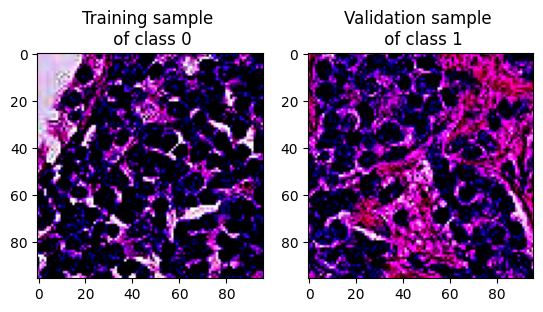

In [32]:
# Checkpoint

N_train = train_dataset2.__len__()
train_sample = train_dataset2.__getitem__(0)[0]
train_sample_target = train_dataset2.__getitem__(0)[1]
train_shape = train_sample.shape

print("The training dataset consists of {} images of shape ({}, {}, {})".format(N_train, train_shape[0], train_shape[1], train_shape[2]))

N_val = val_dataset2.__len__()
val_sample = val_dataset2.__getitem__(0)[0]
val_sample_target = val_dataset2.__getitem__(0)[1]
val_shape = val_sample.shape

print("The validation dataset consists of {} images of shape ({}, {}, {})".format(N_val, val_shape[0], val_shape[1], val_shape[2]))
print()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_sample.permute((2,1,0)))
axs[0].set_title("Training sample \n of class {}".format(train_sample_target))

axs[1].imshow(val_sample.permute((2,1, 0)))
axs[1].set_title("Validation sample \n of class {}".format(val_sample_target))
plt.show()


### Task 3: Create DataLoaders

**Instructions:**
1. Create DataLoaders for the training and validation dataset.
2. Consider advantages and disavdavtanges of high or low values of batch size and pick a sensible value.

In [33]:
# train_loader = ....
# val_loader = ....

train_loader = DataLoader(train_dataset2, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset2, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training DataLoader will yield 4096 batches of length 64
Validation DataLoader will yield 512 batches of length 64

Checking some samples from a batch:


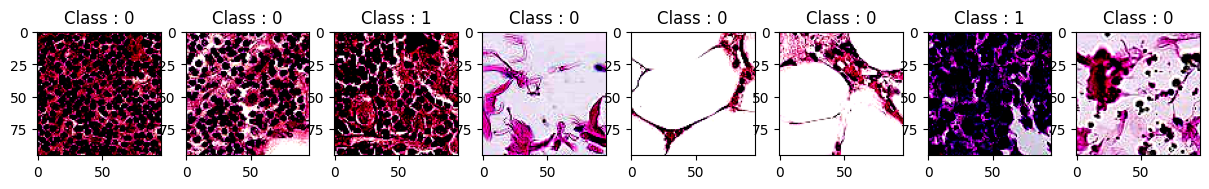

In [34]:
# Checkpoint
print("Training DataLoader will yield {} batches of length {}".format(train_loader.__len__(), train_loader.batch_size))
print("Validation DataLoader will yield {} batches of length {}".format(val_loader.__len__(), val_loader.batch_size))
print()

print("Checking some samples from a batch:")
X_batch, y_batch = next(iter(val_loader))
fig, ax = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    ax[i].imshow(X_batch[i].permute((1, 2, 0)))
    ax[i].set_title("Class : {}".format(y_batch[i].item()))
plt.show()

### Task 4: Implement a linear classifier (Perceptron or Logistic Regression) using PyTorch

**Instructions:**
1. Use PyTorch layers to build the classifier.
2. Implement a forward function to handle batches of input data.
3. Before using the model, make sure to move it to the GPU.

**Hint:**
Think about a special type of linear layers that is well-suited for image data.

In [35]:
# build custom module for logistic regression
class LogisticRegression(torch.nn.Module):    
    # build the constructor
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    # make predictions
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

n_inputs = 96*96*3
n_classes = 1

device = torch.device("cuda")
model = LogisticRegression(n_inputs, n_classes)

model.to(device)

LogisticRegression(
  (linear): Linear(in_features=27648, out_features=1, bias=True)
)

In [36]:
val_dataset.__getitem__(0)[0].shape

torch.Size([3, 96, 96])

In [25]:
# Checkpoint

def calc_accuracy(model, data_loader):
    # evaluate val loss
    acc = 0
    for x, y in tqdm(data_loader):
        x = torch.reshape(x,(64,96*96*3)).to("cuda")
        y = y.unsqueeze(1).float().to(device)
        y_pred = model(x)
        acc += ((y_pred > 0.5) == y).sum().item()
    acc /= (len(data_loader)*data_loader.batch_size)
    return acc

def check_cuda(model):
    if next(model.parameters()).is_cuda:
        print("Model is on CUDA device.")
    else:
        print("Error: Model is not on CUDA device. Please move the model to CUDA.")
        # You can also move the model to CUDA using the following line:


check_cuda(model)
val_acc = calc_accuracy(model, val_loader)
print("The validation accuracy of the untrained model is: {}".format(val_acc))

Model is on CUDA device.


100%|█████████████████████████████████████████████████████████████████████████████████| 512/512 [01:11<00:00,  7.13it/s]

The validation accuracy of the untrained model is: 0.520904541015625


### Task 5: Implement the training loop

**Instructions:**
1. Define the loss function and pick an appropriate optimizer.
2. Identify possible hyperparameters and pick sensible values for them.
3. Implement a loop over training set batches to train the model.
4. Implement an early stopping criterion to prevent overfitting.

In [ ]:
from torch import nn
                       
epochs = 10                        
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # try changing to Adam
Loss = []
acc = []

for epoch in range(epochs):
    for x, y in tqdm(train_loader):
        x = torch.reshape(x,(64,96*96*3)).to("cuda")
        y = y.unsqueeze(1).float().to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    print('Epoch: {}. Loss: {}.'.format(epoch+1, Loss[epoch])) 


 49%|██████████████████████████████████████▌                                        | 1999/4096 [02:29<02:38, 13.26it/s]

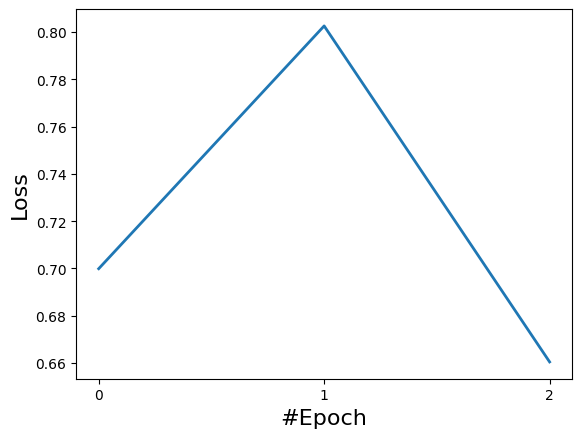

In [39]:
from matplotlib.ticker import MaxNLocator

epochs_array = np.arange(epochs)
epochs_array

plt.plot(epochs_array, Loss, linewidth = 2, label = "Training loss")
plt.ylabel(r"Loss", fontsize = 16)
plt.xlabel(r"#Epoch", fontsize = 16)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.plot(epochs_array, Loss_val, linewidth = 2, label = "Validation loss")
plt.show()

### Task 6: Make predictions on the test set

**Instructions:**
1. Implement a DataLoader for the PCAM test split if not already done. Note that we have removed the test labels from the cluster directory. Do not shuffle the data!
2. Execute the provided code to make predictions for the test split and save your predictions as a CSV file.
3. Send the CSV file containing your predictions to florianbley@gmx.de

In [42]:
batch_size = 64

class Class2(Dataset):
    def __init__(self, file_path_d, transform=None):
        self.file_d = h5py.File(file_path_d, 'r')
        self.data = self.file_d['x']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = (torch.from_numpy(self.data[idx]).permute((2,0,1)))

        if self.transform:
            sample = self.transform(sample)
        return sample


test_dataset = Class2("data/camelyonpatch_level_2_split_test_x.h5", transform = transform1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
import pandas as pd

def save_test_predictions(model, test_loader):
    test_preds = []
    for x in tqdm(test_loader):
        x = torch.reshape(x,(64,96*96*3)).to("cuda")
        y_pred = model(x).int().cpu()
        test_preds.append(y_pred)
    result_df = pd.DataFrame(torch.stack(test_preds).reshape(-1).numpy(), columns=["predicted label"])
    result_df.to_csv("predicted_labels.csv", index=False)
save_test_predictions(model, test_loader)

/tmp/ipykernel_1489016/2132093689.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
100%|█████████████████████████████████████████████████████████████████████████████████| 512/512 [00:09<00:00, 54.66it/s]
